# IEEE-CIS Fraud Detection

## Integrating machine learning to detect fraud

Industries and individuals are suffering from fraudulent damages. As noted from [SearchSecurity.com](https://searchsecurity.techtarget.com/definition/fraud-detection), fraud can be define as money or property being obtained through false pretenses. Implementing effective and accurate fraud prevention systems can save businesses and consumers millions of dollars. With the goal of improving customer experience, [IEEE Computational Intelligence Society](https://cis.ieee.org/) has partnered with payment service company, [Vesta Corporation](https://trustvesta.com/), to find more effective solutions for fraud prevention. 

In this project, we will be participating in this competition and using Kaggle's competition [IEEE-CIS Fraud Detection](https://www.kaggle.com/c/ieee-fraud-detection) machine dataset. The purpose of the competition is to use historical Vesta's real-world e-commerce transaction to predict whether a transaction is fraud or not. We will employ supervised classification models for this task. 
 * __Supervised__: The goal is to train a model to learn from features to predict the probability of an online fraudulent transaction given labels in the _isFraud_ column. 
 * __Classification__: The label is a binary variable: 0 (not fraud), 1 (fraud)
 
### Overview of Data
There are a total of 5 files: 
 * 1 example submission files 
 * 2 transaction files (test and train)
 * 2 identity files (test and train) 
 
To keep things simple, we will only be using the transaction training set. Below is a [description](https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203) of the attributes in each table. 
 
__Transaction Table__

- TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
- TransactionAMT: transaction payment amount in USD
- ProductCD: product code, the product for each transaction
- card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
- addr: address
- dist: distance
- P_ and (R__) emaildomain: purchaser and recipient email domain
- C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
- D1-D15: timedelta, such as days between previous transaction, etc.
- M1-M9: match, such as names on card and address, etc.
- Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.
- Categorical Features:
- ProductCD
- card1 - card6
- addr1, addr2
- Pemaildomain Remaildomain
- M1 - M9

### Workflow 
 1. Understand the problem (we're almost there already)
 2. Exploratory Data Analysis
 3. Feature engineering to create a dataset for machine learning
 4. Create a baseline machine learning model
 5. Try more complex machine learning models
 6. Optimize the selected model
 7. Investigate model predictions in context of problem
 8. Draw conclusions and lay out next steps

## Metric ROC AUC

Before we begin, let's get an understanding of how each submission is evaluated. For this competition, models are being judged by the Receiver Operating Characteristic Area Under the Curve (ROC AUC), which measures the true positive rate versus the false positive rate. 

ROC AUC measures the probability between 0 and 1. While a score of 0.5 indicates random guessing, better models will receive a higher score. Setting accuracy as the metric isn't recommend since real-world datasets have imbalanced classes. The model will likely be good in predicting the dominant class and misclassify the minority class. In this project, we can anticipate that most transactions are not fraud. If we were to measure based on accuracy, our model would preform well in detecting non-fraud related transactions. That wouldn't be the most effective way in preventing fraud if our model is not good at identifying it. Thus, ROC AUC is used to reflect the accuracy of a classifier.

# Read in Data



In [1]:
# Numpy and pandas
import pandas as pd
import numpy as np

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Statistics tools
import scipy.stats as stats

# Sklearn data clean
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

# Model selection
from sklearn.decomposition import PCA 
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# Logistic Regression
from sklearn.linear_model import Lasso, LogisticRegression

# KNN Classifer 
from sklearn.neighbors import KNeighborsClassifier

# Decision Trees
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from IPython.display import Image
import pydotplus
import graphviz

# Random Forests 
from sklearn.ensemble import RandomForestClassifier

# SVM
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVR
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

# Gradient Boost
from xgboost import XGBClassifier

# Evaluate
from sklearn import metrics
from sklearn.metrics import log_loss,accuracy_score, f1_score,roc_auc_score, confusion_matrix

# Import data
from sqlalchemy import create_engine
import warnings

In [2]:
# List files available
train = pd.read_csv('/Users/tsawaengsri/Desktop/Data Science Courses/Datasets/ieee-fraud-detection/train_transaction.csv')


In [3]:
print('Number of row in transaction:', len(train))

Number of row in transaction: 590540


In [4]:
# Training data
print('Training data shape: ', train.shape)
train.head()

Training data shape:  (590540, 394)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The training data has 590,540 observations (each one a separate online transaction) and 394 attributes including the target variable we want to predict.

In [5]:
print('Number of unique transaction ID in train:', train['TransactionID'].nunique())

Number of unique transaction ID in train: 590540


# Exploratory Data Analysis 
Exploratory Data Analysis (EDA) is an iterative process to explore the data and summarize characteristics by calculating statistics or visualize methods. The purpose of EDA is gain an understanding of the data by identifying trends, anomalies, or relationships that might be helpful when making decisions in the modeling process. 

### Examine the Distribution of the Target Column

We will begin EDA by exploring individual variables, particularly our target variable, _isFraud_. The target is what we are asked to predict: either a 0 for non-fraud transactions, or a 1 for fraud transaction. First, let's examine the number of transactions falling into each category.

In [6]:
train['isFraud'].value_counts()

0    569877
1     20663
Name: isFraud, dtype: int64

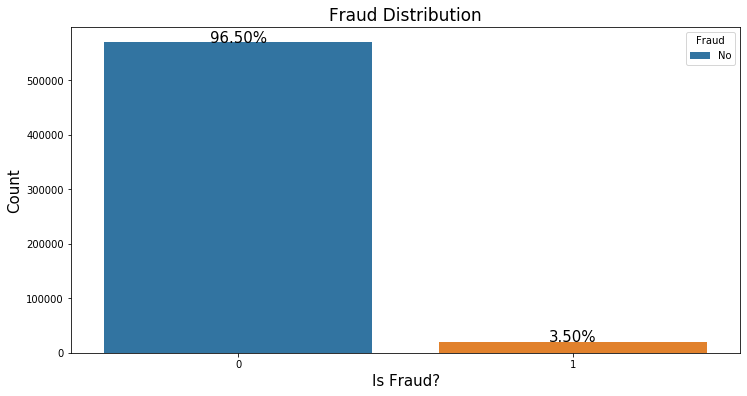

In [7]:
# Plot target variable
plt.figure(figsize=(12,6))
g = sns.countplot(x = 'isFraud', data = train)
g.set_title("Fraud Distribution", fontsize = 17)
g.set_xlabel("Is Fraud?", fontsize = 15)
g.set_ylabel("Count", fontsize = 15)
plt.legend(title='Fraud', labels=['No', 'Yes'])

for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/len(train) * 100),
            ha="center", fontsize=15) 

The fraud rate is 3.50% in the transaction dataset. We can see an imbalanced class problem from the value count and histogram. We may consider mitigating this issue by sampling based approaches. Once we get into more sophisticated machine learning models, we can weight the classes by their representation in the data to reflect this imbalance.

### Column Types
In this section, we will take a look at the numbers of columns of each data type. 

In [8]:
# Number of each type of column
train.dtypes.value_counts()

float64    376
object      14
int64        4
dtype: int64

Let's now look at the number of unique entries in each of the object (categorical) columns.

In [9]:
# Number of unique classes in each object column
train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

ProductCD         5
card4             4
card6             4
P_emaildomain    59
R_emaildomain    60
M1                2
M2                2
M3                2
M4                3
M5                2
M6                2
M7                2
M8                2
M9                2
dtype: int64

Most of the categorical variables have a relatively small number of unique entries. To prevent our model from overfitting, we may consider dropping _P emaildomain_ and _R emaildomain_ since there are more than 30 unique values.

### Missing Values
Now, we will take a look at missing values in each column.

In [10]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [11]:
missing_values_table(train)

Your selected dataframe has 394 columns.
There are 374 columns that have missing values.


,Missing Values,% of Total Values
dist2,552913,93.6
D7,551623,93.4
D13,528588,89.5
D14,528353,89.5
D12,525823,89.0
D6,517353,87.6
D9,515614,87.3
D8,515614,87.3
V157,508595,86.1
V163,508595,86.1


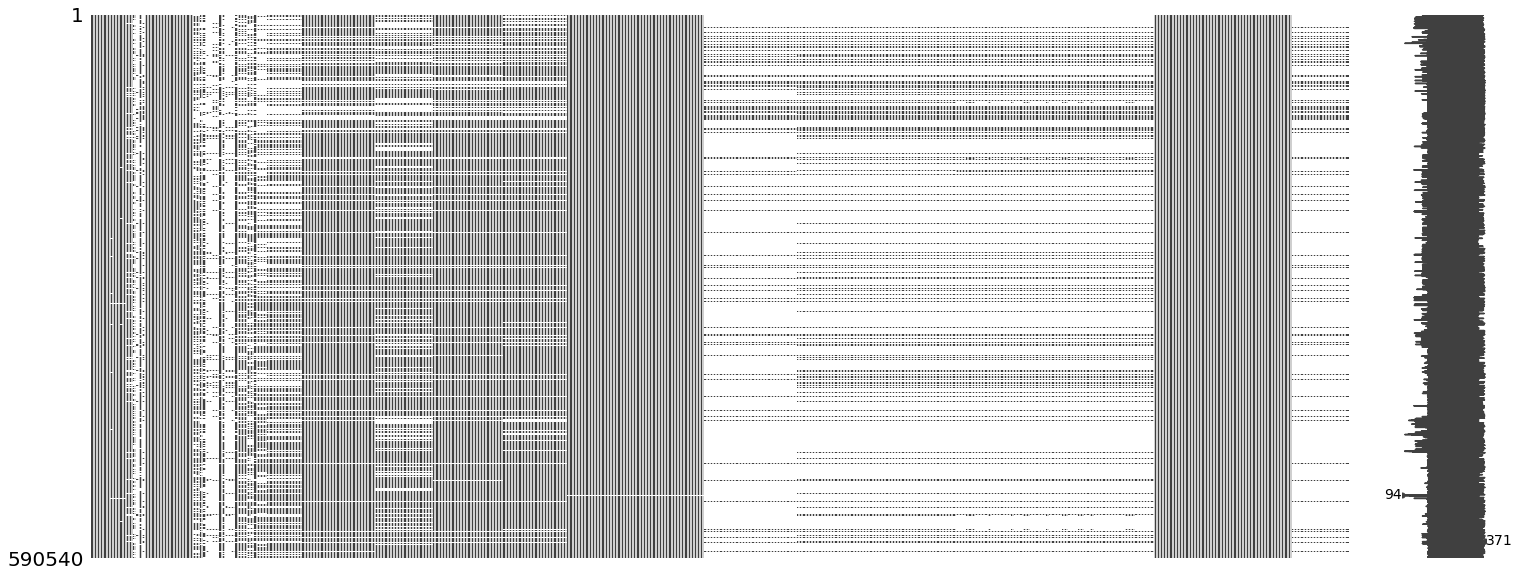

In [12]:
msno.matrix(train)

We can observe that there are missing values in majority of the columns. There appears to be a pattern of missing values among groups of columns. These columns might have been been missing from the same transaction ID. Let's take a closer look at V columns to see if we can get a better insight on the pattern of missing data. 

In [13]:
# Vesta columns 
df_ves = train.filter(regex='V')

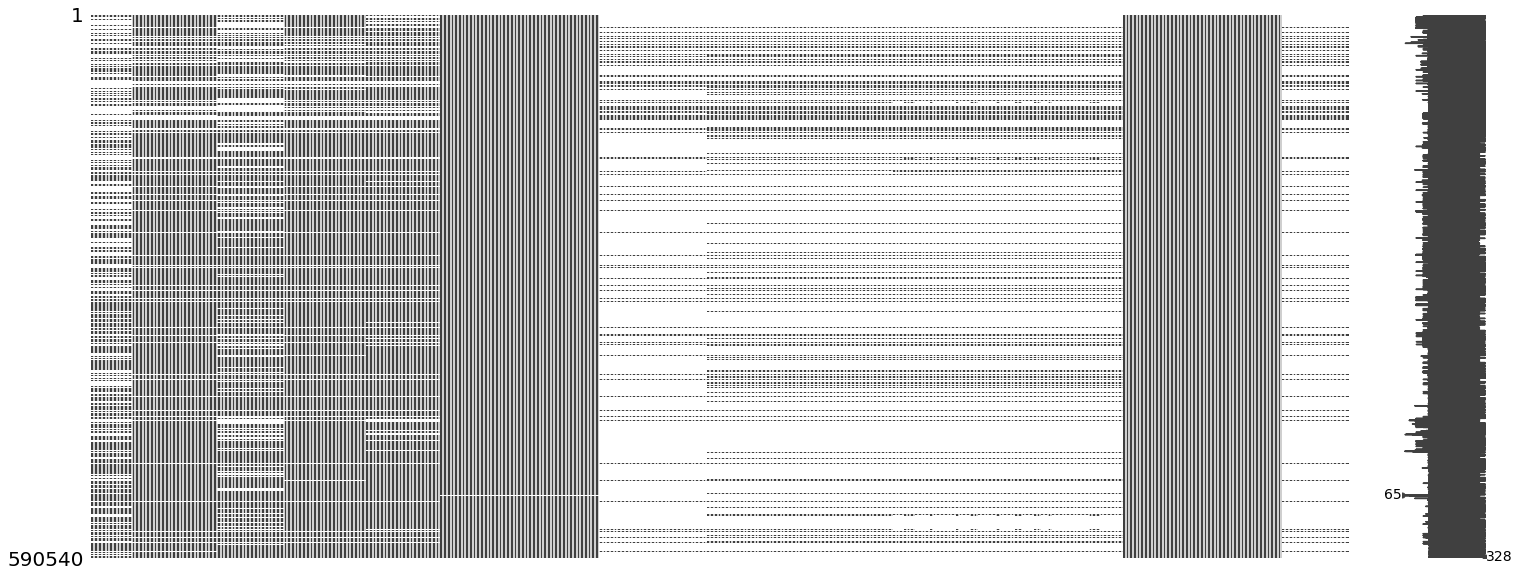

In [14]:
msno.matrix(df_ves)

V columns were featured engineered. Columns with similar missing value patterns may have derived from the same features. Due to  the limited information given on these columns for privacy issues, it is difficult to determine if these columns offer helpful information for predicting fraud.

We may impute these missing values later or use models that can handle missing values.

__Let's see if there is a trend between fraud and increased missing data__

In [15]:
na_df = pd.DataFrame({'missing_count':train.isna().sum(axis=1),'isFraud':train['isFraud']})

Text(0.5, 0, 'Number of missing variables')

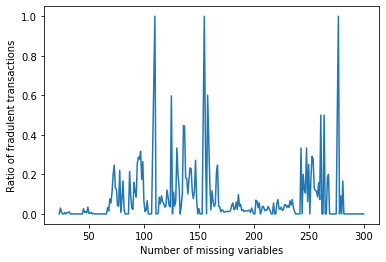

In [16]:
plt.plot(na_df.groupby('missing_count').mean())
plt.ylabel('Ratio of fradulent transactions')
plt.xlabel('Number of missing variables')

There does appear to be a correlation between fraud and increased missing values. 

### Anomalies 
We'll be searching for anomalies within the data.  These may be due to mis-typed numbers, errors in measuring equipment, or they could be valid but extreme measurements. One way to support anomalies quantitatively is by looking at the statistics of a column using the describe method. 


In [17]:
# Statistics 
train.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
count,5.905400e+05,590540.000000,5.905400e+05,590540.000000,590540.000000,581607.000000,588975.000000,586281.000000,524834.000000,524834.000000,...,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.00000,82351.000000,82351.000000,82351.000000,82351.000000
mean,3.282270e+06,0.034990,7.372311e+06,135.027176,9898.734658,362.555488,153.194925,199.278897,290.733794,86.800630,...,0.775874,721.741883,1375.783644,1014.622782,9.807015,59.16455,28.530903,55.352422,151.160542,100.700882
std,1.704744e+05,0.183755,4.617224e+06,239.162522,4901.170153,157.793246,11.336444,41.244453,101.741072,2.690623,...,4.727971,6217.223583,11169.275702,7955.735482,243.861391,387.62948,274.576920,668.486833,1095.034387,814.946722
min,2.987000e+06,0.000000,8.640000e+04,0.251000,1000.000000,100.000000,100.000000,100.000000,100.000000,10.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,3.134635e+06,0.000000,3.027058e+06,43.321000,6019.000000,214.000000,150.000000,166.000000,204.000000,87.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,3.282270e+06,0.000000,7.306528e+06,68.769000,9678.000000,361.000000,150.000000,226.000000,299.000000,87.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
75%,3.429904e+06,0.000000,1.124662e+07,125.000000,14184.000000,512.000000,150.000000,226.000000,330.000000,87.000000,...,0.000000,0.000000,25.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
max,3.577539e+06,1.000000,1.581113e+07,31937.391000,18396.000000,600.000000,231.000000,237.000000,540.000000,102.000000,...,55.000000,160000.000000,160000.000000,160000.000000,55125.000000,55125.00000,55125.000000,104060.000000,104060.000000,104060.000000


Inital observations:
 - Transaction amount varies from /$0.25 to /$31,937
 - Not sure why card 1,2,3,5 are numeric
 - A lot of V columns are 0 

In [18]:
# Categorical Statistics 
train.describe(include=['object'])

,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9
count,590540,588963,588969,496084,137291,319440,319440,319440,309096,240058,421180,244275,244288,244288
unique,5,4,4,59,60,2,2,2,3,2,2,2,2,2
top,W,visa,debit,gmail.com,gmail.com,T,T,T,M0,F,F,F,F,T
freq,439670,384767,439938,228355,57147,319415,285468,251731,196405,132491,227856,211374,155251,205656


Inital observations:

- Product code W is the most popular item
- People pay with mostly debit visa
- Gmail is the most popular email domain
- M4 is not similar to other M columns
- Popular device to access the website is desktop

It is difficult to detect an anomaly from the statistics table. Let's explore the interaction between features and our target variable to see if we can find something interesting. 

## Multivariable Analysis
Now, let's explore how our target variable interacts with other features. 


### Correlation 
To determine which explanatory variables we might select for our prediction model, we will explore the correlation between _isFraud_ and other variables. Correlation refers to a mutal association between variables. Variables that have a strong correlation, whether it being positive or negative, will affect the target variable.


In [19]:
# Find correlations with the target and sort
corr = train.corr()['isFraud'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', corr.tail(15))
print('\nMost Negative Correlations:\n', corr.head(15))

Most Positive Correlations:
 V228       0.268861
V149       0.273282
V156       0.275952
V158       0.278066
V45        0.281832
V258       0.297151
V188       0.303582
V189       0.308219
V200       0.318783
V201       0.328005
V242       0.360590
V244       0.364129
V246       0.366878
V257       0.383060
isFraud    1.000000
Name: isFraud, dtype: float64

Most Negative Correlations:
 D8    -0.142636
D7    -0.127199
V48   -0.115786
V49   -0.110920
V90   -0.110168
V29   -0.107852
V91   -0.105453
V69   -0.104521
V30   -0.103088
V70   -0.100900
D2    -0.083583
D15   -0.077519
V35   -0.077116
V10   -0.074658
D10   -0.072002
Name: isFraud, dtype: float64


Based on the correlation list, our target variable is not highly correlated to many variables so we will first examine the features by categories. 


_Categorical Features_
 * ProductCD: product code
 * card4, card6: card information 
 * P_emaildomain: purchaser email domain
 * R_emaildomain: recipient email domain
 * M1 - M9: match (names on card, address, etc)
 
_Numeric Features_
 * TransactionDT: timedelta from a given reference datetime
 * TransactionAMT: transaction payment amount in USD
 * card1-3, card5: card information 
 * dist: distance
 * addr1, addr2: address 
 * C1-C4: counting
 * D1-D15: timedelta (time between previous transaction)
 * V1-V339: Vesta engineered features

 
### Categorical Variables 
We'll start with exploring categorical variables. 

In [20]:
# Function to visualize categorical variables
def visualize_cat_var(variable, df=train):
    df[variable].fillna("NA", inplace=True)
    # If normalize is True then the object returned will contain the relative frequencies of the unique values.
    variable_fraud_rate = df.groupby(variable)['isFraud'].value_counts(normalize = True).unstack().fillna(0)[1]
    
    plt.figure(figsize=(12,6))

    g = sns.countplot(x = variable, data = train, order = variable_fraud_rate.index)
    g.set_title('{} Count'.format(variable), fontsize = 15)
    g.set_xlabel("{}".format(variable), fontsize=15)
    g.set_ylabel("Count", fontsize=15)
    plt.xticks(rotation= "vertical")

    r = g.twinx()
    r = sns.pointplot(x = variable_fraud_rate.index, y = variable_fraud_rate, color = "blue")
    r.set_ylabel("Fraud Rate", fontsize = 16, color = "blue")

### Product CD
Product code represent the product for each transaction.<br>

“Product isn't necessary to be a real 'product' (like one item to be added to the shopping cart). It could be any kind of service.”

__Which Product C has the highest fraud rate?__

In [21]:
train[train['isFraud'] == 1]['ProductCD'].value_counts(normalize = True)

W    0.434061
C    0.387553
H    0.076175
R    0.069012
S    0.033199
Name: ProductCD, dtype: float64

In [22]:
# Group by Product CD 
train.groupby('ProductCD')['isFraud'].value_counts(normalize = True)

ProductCD  isFraud
C          0          0.883127
           1          0.116873
H          0          0.952338
           1          0.047662
R          0          0.962174
           1          0.037826
S          0          0.941004
           1          0.058996
W          0          0.979601
           1          0.020399
Name: isFraud, dtype: float64

W is the most fequent product category. In terms of the fraud rate per product code, product C has the highest count of fraud. 

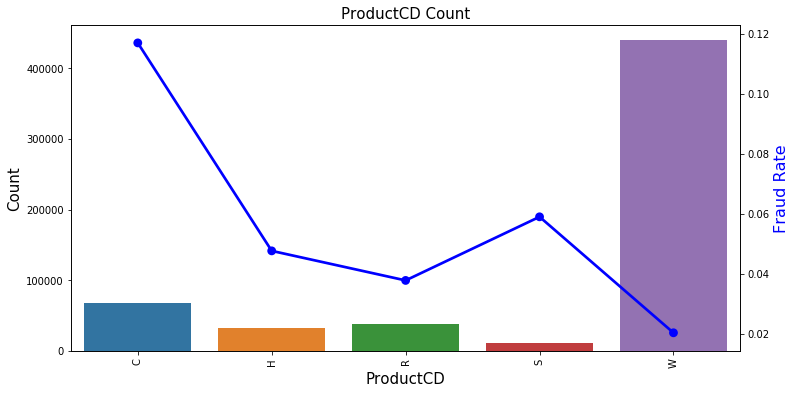

In [23]:
# Plot Product CD Distribution
visualize_cat_var('ProductCD')

As we normalize the dataset, the fraud rate for Product W reduces from 43.4% to 2%. Product C has the highest fraud rate per unique value (11.6%)

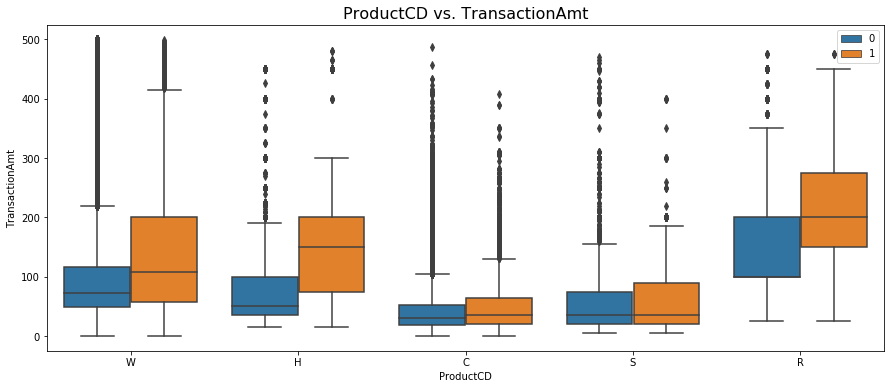

In [24]:
fig, ax = plt.subplots(figsize=(15, 6))

sns.boxplot(x="ProductCD", y="TransactionAmt", hue="isFraud",
                   data=train.query('TransactionAmt < 500'),
                   ax=ax).set_title('ProductCD vs. TransactionAmt', fontsize=16)
plt.legend(loc='upper right')
plt.show()

From the boxplot, we can see that fraud tends to occur among higher priced items. 

### Card Type
These columns represent payment card information, such as card type, card category, issue bank, country, etc.

Card 1, 2, 3, and 5 are numeric variables in this dataset. However, the numeric values are probably represent categories.

__Which card has the highest fraud rate?__

In [25]:
card_cols = [c for c in train.columns if 'card' in c]
train[card_cols].head()

,card1,card2,card3,card4,card5,card6
0,13926,NaN,150.0,discover,142.0,credit
1,2755,404.0,150.0,mastercard,102.0,credit
2,4663,490.0,150.0,visa,166.0,debit
3,18132,567.0,150.0,mastercard,117.0,debit
4,4497,514.0,150.0,mastercard,102.0,credit


In [26]:
train.loc[:,'card1':'card6'].nunique()

card1    13553
card2      500
card3      114
card4        4
card5      119
card6        4
dtype: int64

From looking at the head of the table, card 4 contains information of card network. Card 6 describes the type of payment. 

Card 1, 2, 3, and 5 are harder to interpet. Card 1 contains 13,553 unique values which may have been some form of card ID. Card 2, 3, and 4 could be other card information such as expiration date. 

__Card 4__


In [27]:
train[train['isFraud'] == 1]['card4'].value_counts(normalize = True)

visa                0.648482
mastercard          0.315003
discover            0.024925
american express    0.011590
Name: card4, dtype: float64

Visa accounts for 64% of all fraud occurences. It probably is the most popular card type.

In [28]:
train.groupby('card4')['isFraud'].value_counts(normalize = True)

card4             isFraud
american express  0          0.971302
                  1          0.028698
discover          0          0.922718
                  1          0.077282
mastercard        0          0.965669
                  1          0.034331
visa              0          0.965244
                  1          0.034756
Name: isFraud, dtype: float64

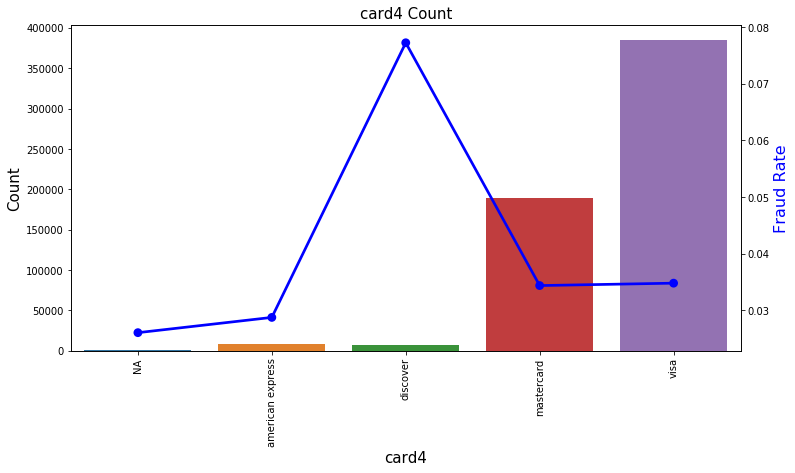

In [29]:
# Plot Card 4
visualize_cat_var('card4')

 When normalized by total number of each type, Discovery cards has the highest fraud rate: 7.7%.
 
 __Card 6__

In [30]:
train[train['isFraud'] == 1]['card6'].value_counts(normalize = True)

debit     0.517552
credit    0.482448
Name: card6, dtype: float64

In [31]:
train.groupby('card6')['isFraud'].value_counts(normalize = True)

card6            isFraud
charge card      0          1.000000
credit           0          0.933215
                 1          0.066785
debit            0          0.975737
                 1          0.024263
debit or credit  0          1.000000
Name: isFraud, dtype: float64

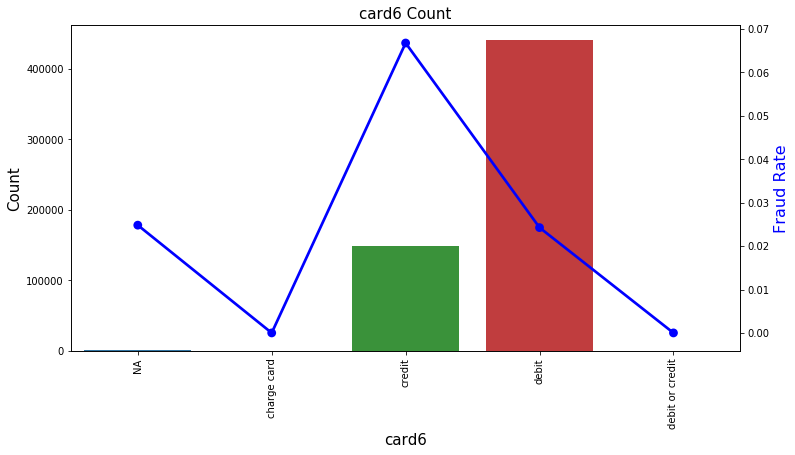

In [32]:
# Card 6
visualize_cat_var('card6')

Fraud rate for credit cards are much higher (6.6%) than  debit cards (2.4%).

### Email Domain
P_ and (R_) emaildomain: purchaser and recipient email domain “ certain transactions don't need recipient, so R_emaildomain is null.”

__Which email domain has the highest fraud rate?__


In [33]:
email_cols = [c for c in train.columns if 'email' in c]
train[email_cols].head()

,P_emaildomain,R_emaildomain
0,NaN,NaN
1,gmail.com,NaN
2,outlook.com,NaN
3,yahoo.com,NaN
4,gmail.com,NaN



__Purcahser Email Domain__

In [34]:
email_fraud = train[train['isFraud'] == 1]['P_emaildomain'].value_counts(normalize = True)
email_fraud.head()

gmail.com        0.556314
hotmail.com      0.134057
yahoo.com        0.128518
anonymous.com    0.048061
aol.com          0.034521
Name: P_emaildomain, dtype: float64

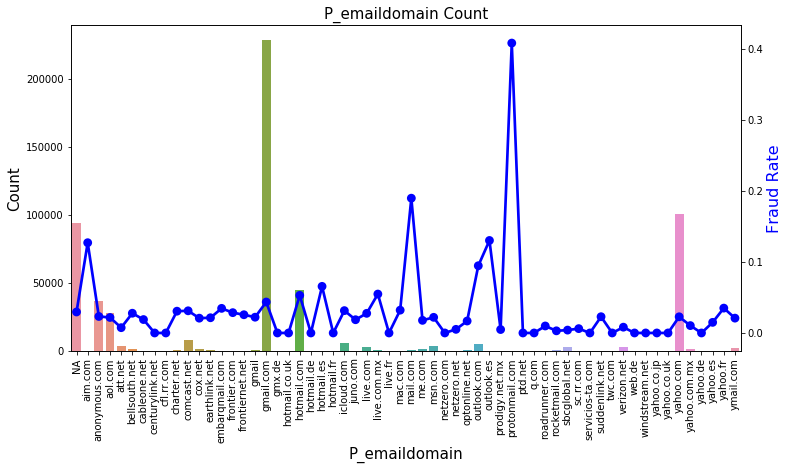

In [35]:
# Plot purchaser email domain
visualize_cat_var('P_emaildomain')

The most popular email domains are gmail.com, yahoo.com, and hotmail.com. They also have the highest occurance of fraud. 

In terms of fraud rate, almost 80% of transactions from purchaser using protonmail.com were label fraud.

__Reciever Email Domain__

In [36]:
email_fraud = train[train['isFraud'] == 1]['R_emaildomain'].value_counts(normalize = True)
email_fraud.head()

gmail.com        0.606663
hotmail.com      0.190612
yahoo.com        0.054333
anonymous.com    0.053264
outlook.com      0.036875
Name: R_emaildomain, dtype: float64

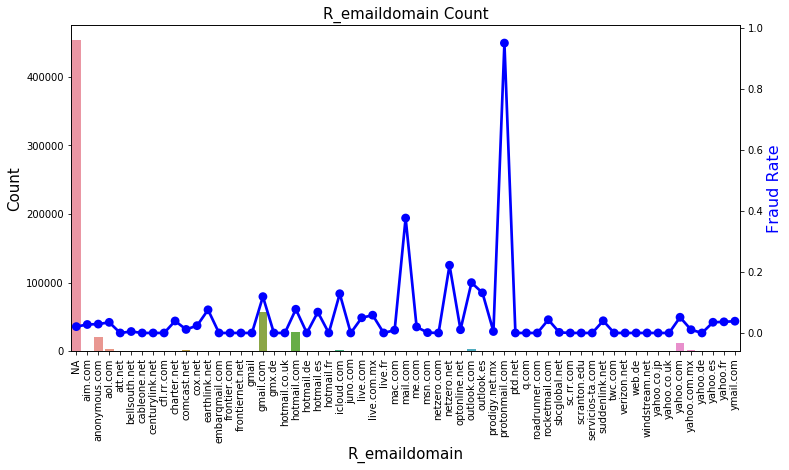

In [37]:
# Plot reciever email domain
visualize_cat_var('R_emaildomain')

Similar to purchaser email domain, protonmail recieved the most fraud rate.

### M1-M9
M columns represent matches such as names on card and address, etc.

In [38]:
m_cols = [c for c in train.columns if c[0] == 'M']
train[m_cols].head()

,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,T,T,T,M2,F,T,NaN,NaN,NaN
1,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN
2,T,T,T,M0,F,F,F,F,F
3,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
train.loc[:,'M1':'M9'].nunique()

M1    2
M2    2
M3    2
M4    3
M5    2
M6    2
M7    2
M8    2
M9    2
dtype: int64

It looks like most M columns are binary variables with a T and F representing True and False match respectively. Let's take  a closer look at M4 since there are 3 unique values. 

__M4__

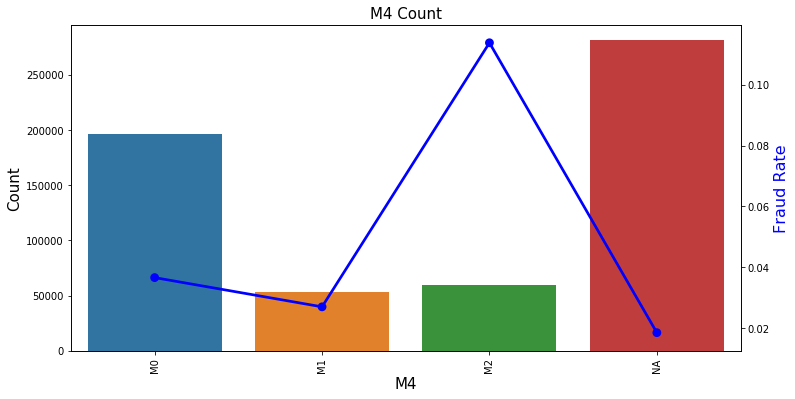

In [40]:
visualize_cat_var('M4')

It looks like M4 contains the match count for M0, M1, and M2. There isn't much information on what each M column represent, but M2 appears to have the highest fraud rate, which is over 10%. 

## Numerical Features
Now, we will continue EDA by exploring the interaction between our target variable and the remaining numerical variables. Since transaction are usually right skewed, we will anticipate right skewness and incoperate log transformation in our visualize function. 

In [41]:
def visualize_trans_var(variable, df=train):
    plt.figure(figsize=(12,18))
    plt.suptitle('Distribution of: {}'.format(variable), fontsize=22)
    
    plt.subplot(3,2,1)
    sns.distplot(df[variable], kde= False)
    plt.title('{} Distribution'.format(variable), fontsize = 15)

    plt.subplot(3,2,2)
    sns.distplot(np.log10(df[variable]), kde= False)
    plt.title('Log-transformed Distribution', fontsize = 15)


    plt.subplot(3,2,3)
    sns.distplot(df[df['isFraud'] == 0][variable], color = 'skyblue', kde= False, label = 'Not Fraud')
    sns.distplot(df[df['isFraud'] == 1][variable], color = 'red', kde= False , label = 'Fraud')
    plt.title('Fraud vs Non-Fraud Distribution', fontsize = 15)
    plt.legend()

    plt.subplot(3,2,4)
    sns.distplot(np.log10(df[df['isFraud'] == 0][variable]), color = 'skyblue', kde= False, label = 'Not Fraud')
    sns.distplot(np.log10(df[df['isFraud'] == 1][variable]), color = 'red', kde= False , label = 'Fraud')
    plt.title('Log-transformed Distribution', fontsize = 15)
    plt.legend()


In [42]:
# Function to visualize numeric variables
def visualize_num_var(variable, df=train):
    # check for homogeneity:
    if len(df[variable].unique()) <= 1:
        print('{} is a homogeneous set'.format(variable))
        return
    
    # check for NAs and Zeros
    if df[variable].isnull().values.any():
        df = train.dropna(subset=[variable])

    if df[variable].min() < 0:
        plt.figure(figsize=(12,12))
        plt.suptitle('Distribution of: {}'.format(variable), fontsize=22)
    
        plt.subplot(2,2,1)
        sns.distplot(df[variable], kde= False)
        plt.title('{} Distribution'.format(variable), fontsize = 15)
        
        plt.subplot(2,2,2)
        sns.distplot(df[df['isFraud'] == 0][variable], color = 'skyblue', kde= False, label = 'Not Fraud')
        sns.distplot(df[df['isFraud'] == 1][variable], color = 'red', kde= False , label = 'Fraud')
        plt.title('Fraud vs Non-Fraud Distribution', fontsize = 15)
        plt.legend()
        
    else:
        smallest_value = df[df[variable] != 0][variable].min()
            
        if df[variable].min() == 0:
            df[variable].replace(0, smallest_value/10, inplace=True)       

        plt.figure(figsize=(12,18))
        plt.text(x=0.5, y=0.5,
                 s="Zeros have been replaced with {} to avoid log infinity".format(smallest_value/10),
                 fontsize=12,horizontalalignment='center')

        plt.suptitle('Distribution of: {}'.format(variable), fontsize=22)

        plt.subplot(3,2,1)
        sns.distplot(df[variable], kde= False)
        plt.title('{} Distribution'.format(variable), fontsize = 15)

        plt.subplot(3,2,2)
        sns.distplot(np.log10(df[variable]), kde= False)
        plt.title('Log-transformed Distribution', fontsize = 15)
        
        plt.subplot(3,2,3)
        sns.distplot(df[df['isFraud'] == 0][variable], color = 'skyblue', kde= False, label = 'Not Fraud')
        sns.distplot(df[df['isFraud'] == 1][variable], color = 'red', kde= False , label = 'Fraud')
        plt.title('Fraud vs Non-Fraud Distribution', fontsize = 15)
        plt.legend()

        plt.subplot(3,2,4)
        sns.distplot(np.log10(df[df['isFraud'] == 0][variable]), color = 'skyblue', kde= False, label = 'Not Fraud')
        sns.distplot(np.log10(df[df['isFraud'] == 1][variable]), color = 'red', kde= False , label = 'Fraud')
        plt.title('Log-transformed Distribution', fontsize = 15)
        plt.legend()


### TransactionDT
This column is defined as time delta from a given reference datetime (not an actual timestamp). 

Lynn@Vesta commented in one of the discussion post:

_"We define reported chargeback on card, user account, associated email address and transactions directly linked to these attributes as fraud transaction (isFraud=1); If none of above is found after 120 days, then we define as legit (isFraud=0)"_

In [43]:
train['TransactionDT'].head()

0    86400
1    86401
2    86469
3    86499
4    86506
Name: TransactionDT, dtype: int64

Text(0.5, 1.0, 'Distribution of TransactionDT')

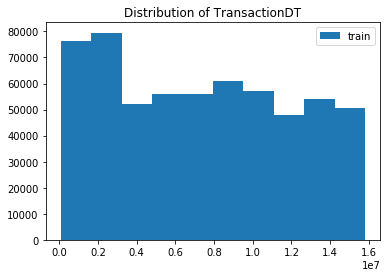

In [44]:
# Plot distribution of Transaction delta time
plt.hist(train['TransactionDT'], label='train')
plt.legend()
plt.title('Distribution of TransactionDT')

The plot suggests there to be a time gap between the training and testing dataset. Currently, the time measurement for this column has not been determined. 

Some have suggested the following:

_“TransactionDT first value is 86400, which corresponds to the number of seconds in a day (60 * 60 * 24 = 86400) so I think the unit is seconds. Using this, we know the data spans 6 months, as the maximum value is 15811131, which would correspond to day 183.”_

### Transaction Amount
This is the transaction payment amount in USD. <br>


“Some of the transaction amounts have three decimal places to the right of the decimal point. There seems to be a link to three decimal places and a blank addr1 and addr2 field. Is it possible that these are foreign transactions and that, for example, the 75.887 in row 12 is the result of multiplying a foreign currency amount by an exchange rate?”

Let's take the log to treat the right skew of the transaction distribution. 

/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


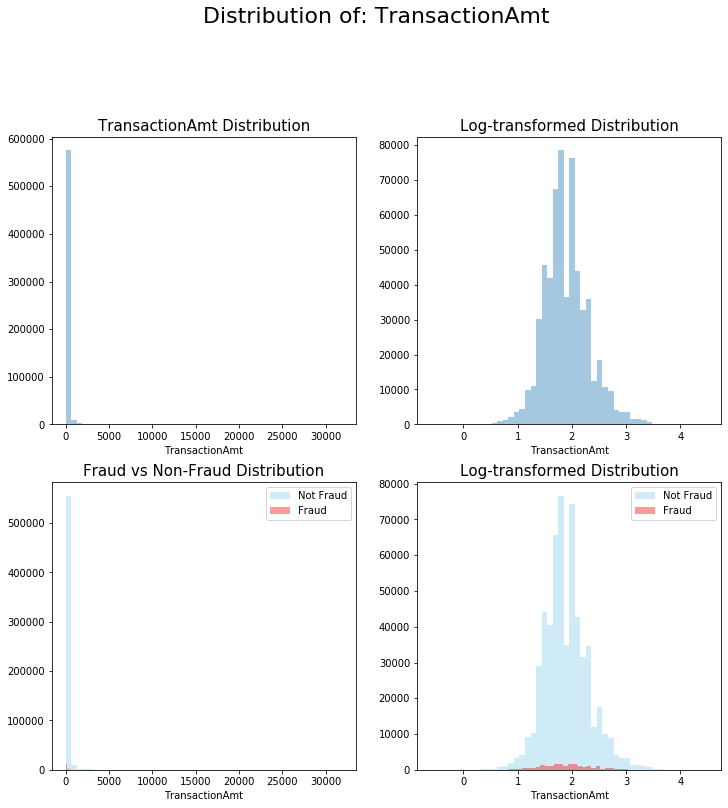

In [45]:
visualize_trans_var('TransactionAmt')

After taking the log of the transaction amount, we can see see that most fraud occur among lower priced items.

### Distance 1 and 2
This can be interpeted as distances between (not limited) billing address, mailing address, zip code, IP address, phone area, etc.

/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:6788: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


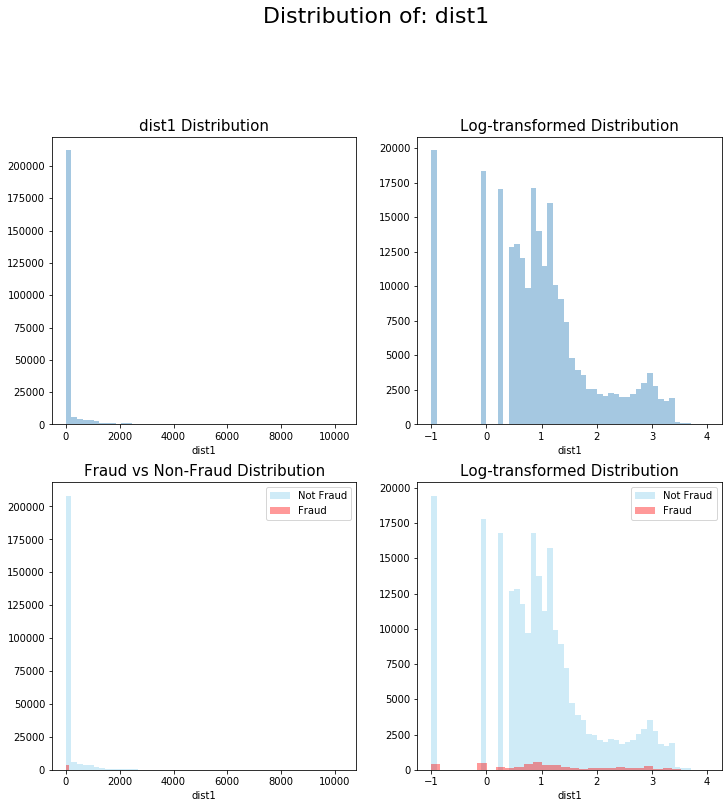

In [46]:
visualize_num_var('dist1')

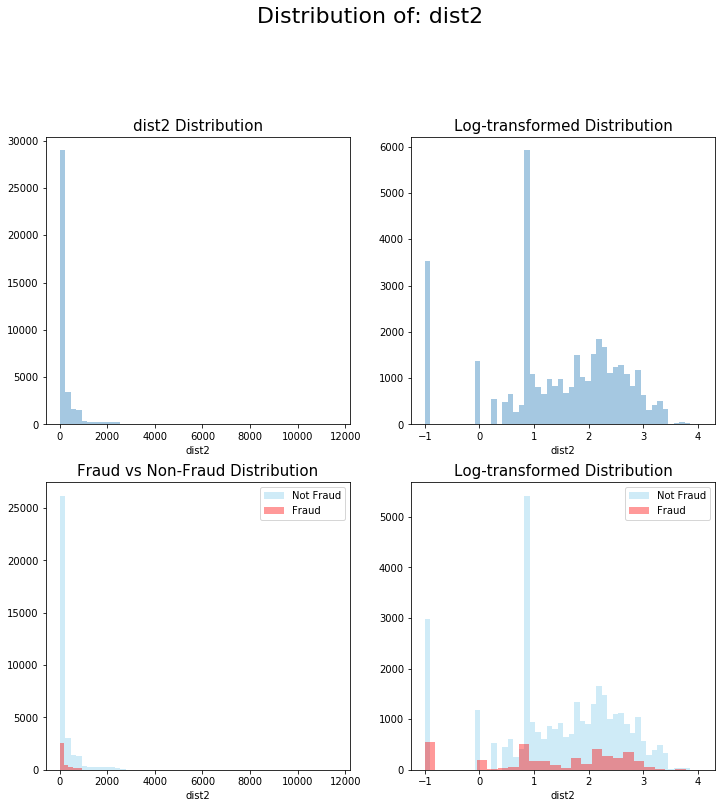

In [47]:
visualize_num_var('dist2')

Both the distance distribution is highly right skewed.

### Address 
The address columns refer to the purchaser information. _Addr1_ is the billing region and _addr2_ is the billing country.

In [48]:
print(' addr1 - has {} NA values'.format(train['addr1'].isna().sum()))
print(' addr2 - has {} NA values'.format(train['addr2'].isna().sum()))

 addr1 - has 65706 NA values
 addr2 - has 65706 NA values


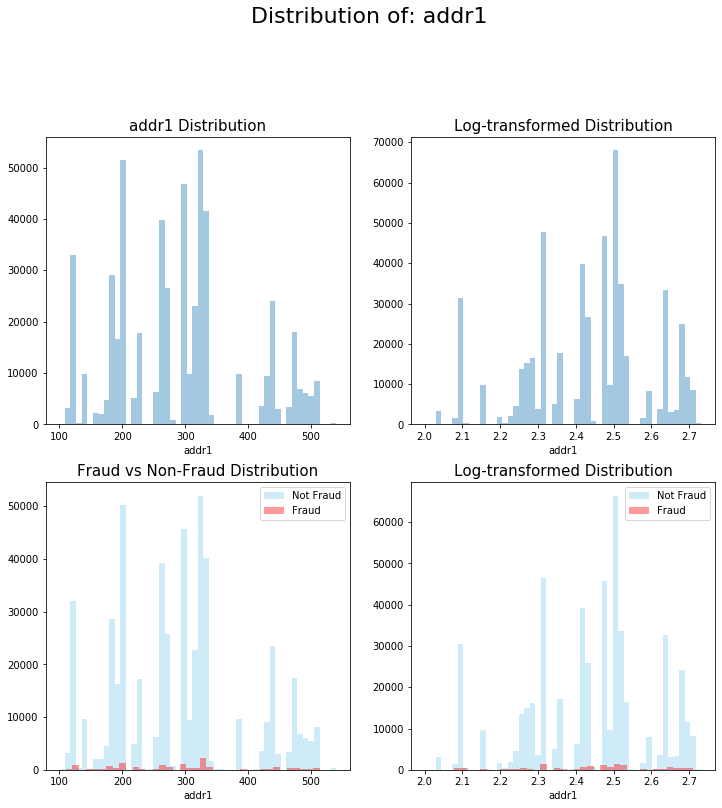

In [49]:
visualize_num_var('addr1')

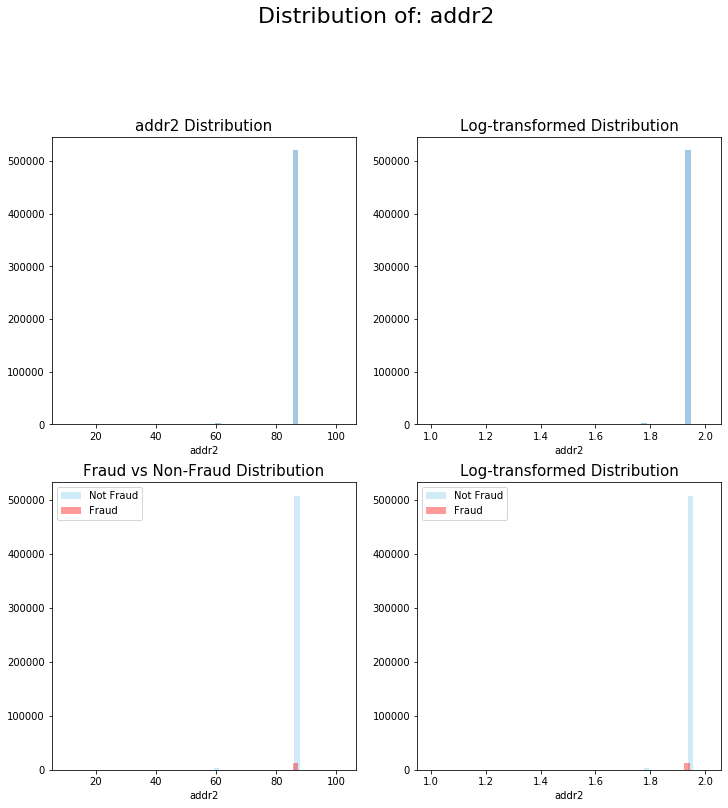

In [50]:
visualize_num_var('addr2')

There appears to be many missing address for the second column. 

### C1 - C14
C columns are counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.

In [51]:
c_cols = [c for c in train if c[0] == 'C']
train[c_cols].head()

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0
1,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
2,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
3,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0
4,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0


In [52]:
train.loc[:,'C1':'C14'].nunique()

C1     1657
C2     1216
C3       27
C4     1260
C5      319
C6     1328
C7     1103
C8     1253
C9      205
C10    1231
C11    1476
C12    1199
C13    1597
C14    1108
dtype: int64

Let's check out C3 since there are only 27 unique values. 

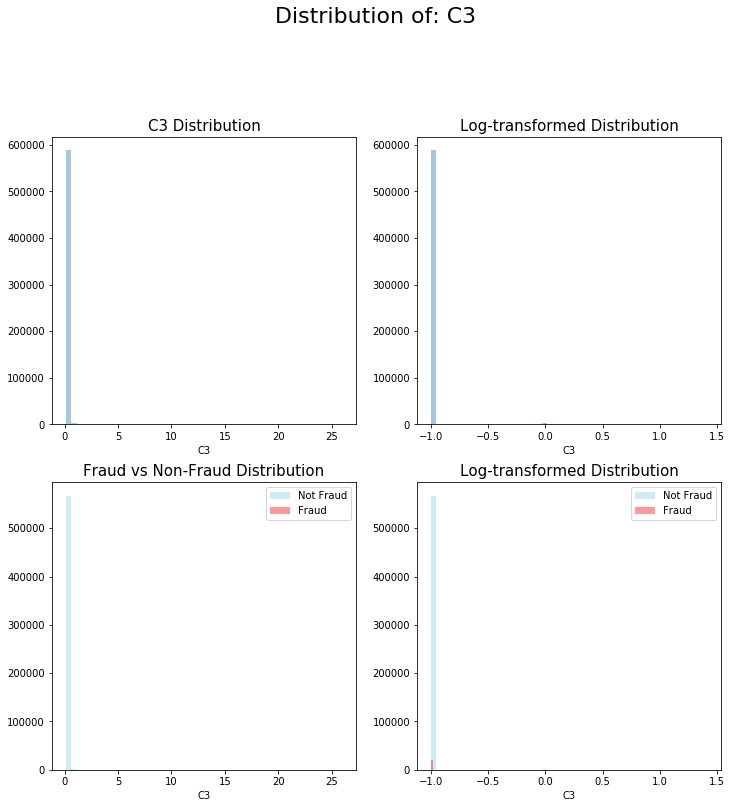

In [53]:
visualize_num_var('C3')

Well, these graphs aren't helpful.

### D1-D9
D columns are timedelta, such as days between previous transaction, etc.

In [54]:
d_cols = [c for c in train if c[0] == 'D']
train[d_cols].head()

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15
0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0
1,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0
2,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,315.0
3,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,111.0
4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
train.loc[:,'D1':'D9'].nunique()

D1      641
D2      641
D3      649
D4      808
D5      688
D6      829
D7      597
D8    12353
D9       24
dtype: int64

Let's check out D2, D7, and D8 since these attributes are most negatively correlated to _isFraud_.

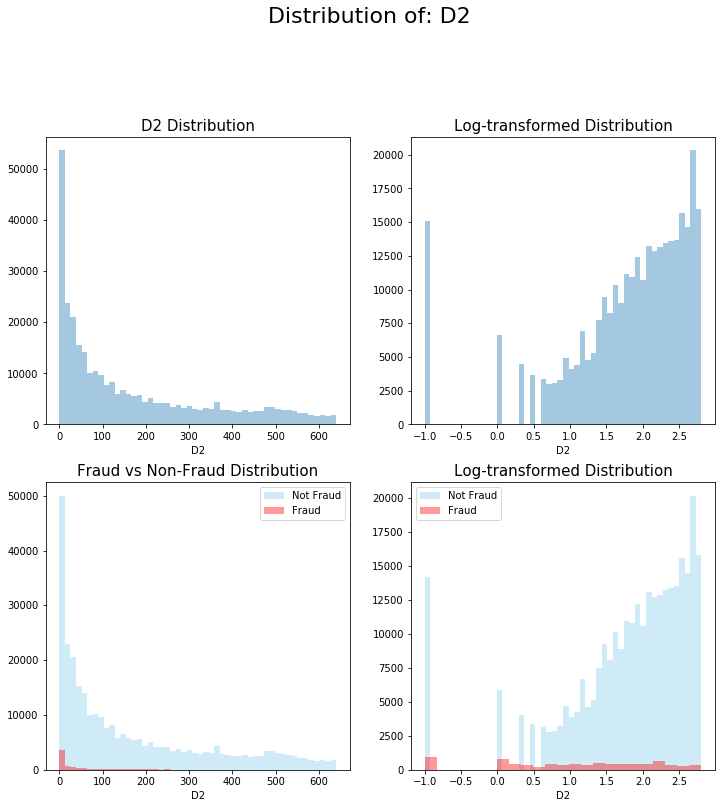

In [56]:
visualize_num_var('D2')

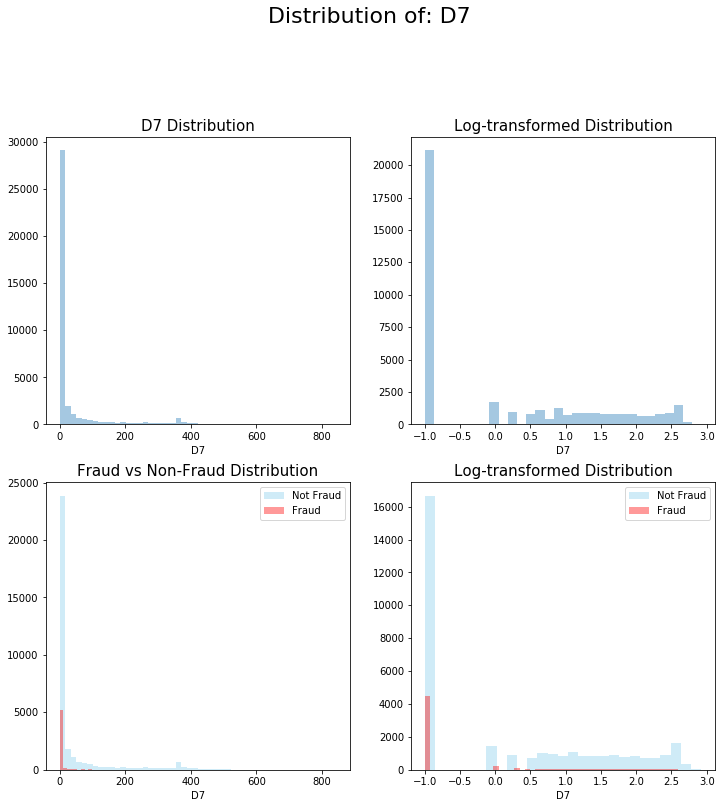

In [57]:
visualize_num_var('D7')

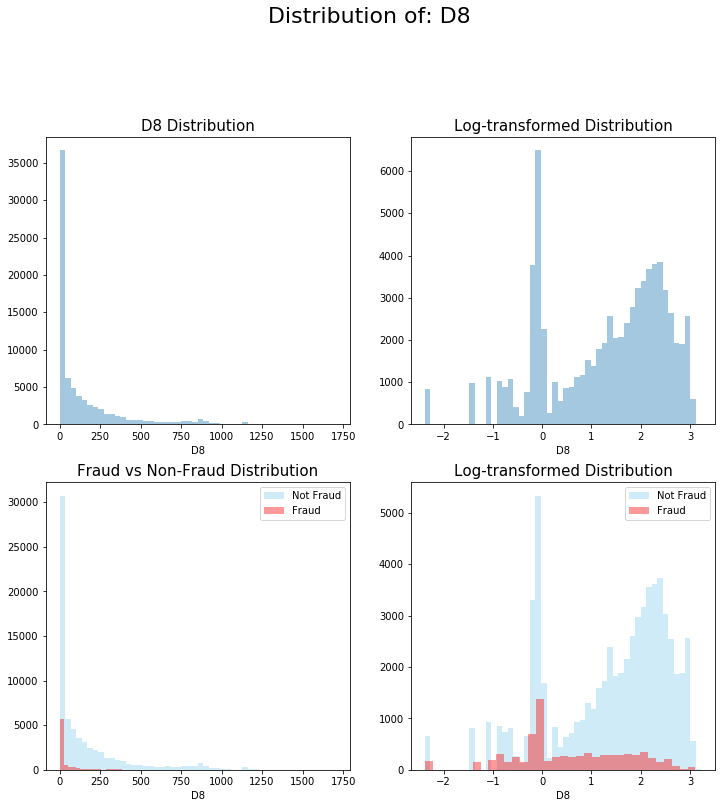

In [58]:
visualize_num_var('D8')

### V1-V339
These are Vesta engineered rich features, including ranking, counting, and other entity relations.

“For example, how many times the payment card associated with a IP and email or address appeared in 24 hours time range, etc.”

"All Vesta features were derived as numerical. Some of them are count of orders within a clustering, a time-period or condition, so the value is finite and has ordering (or ranking). I wouldn't recommend to treat any of them as categorical. If any of them resulted in binary by chance, it maybe worth trying."

In [59]:
v_cols = [c for c in train if c[0] == 'V']
train[v_cols].head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
train[v_cols].describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
count,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,...,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.00000,82351.000000,82351.000000,82351.000000,82351.000000
mean,0.999945,1.045204,1.078075,0.846456,0.876991,1.045686,1.072870,1.027704,1.041529,0.463915,...,0.775874,721.741883,1375.783644,1014.622782,9.807015,59.16455,28.530903,55.352422,151.160542,100.700882
std,0.007390,0.240133,0.320890,0.440053,0.475902,0.239385,0.304779,0.186069,0.226339,0.521522,...,4.727971,6217.223583,11169.275702,7955.735482,243.861391,387.62948,274.576920,668.486833,1095.034387,814.946722
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,25.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
max,1.000000,8.000000,9.000000,6.000000,6.000000,9.000000,9.000000,8.000000,8.000000,4.000000,...,55.000000,160000.000000,160000.000000,160000.000000,55125.000000,55125.00000,55125.000000,104060.000000,104060.000000,104060.000000


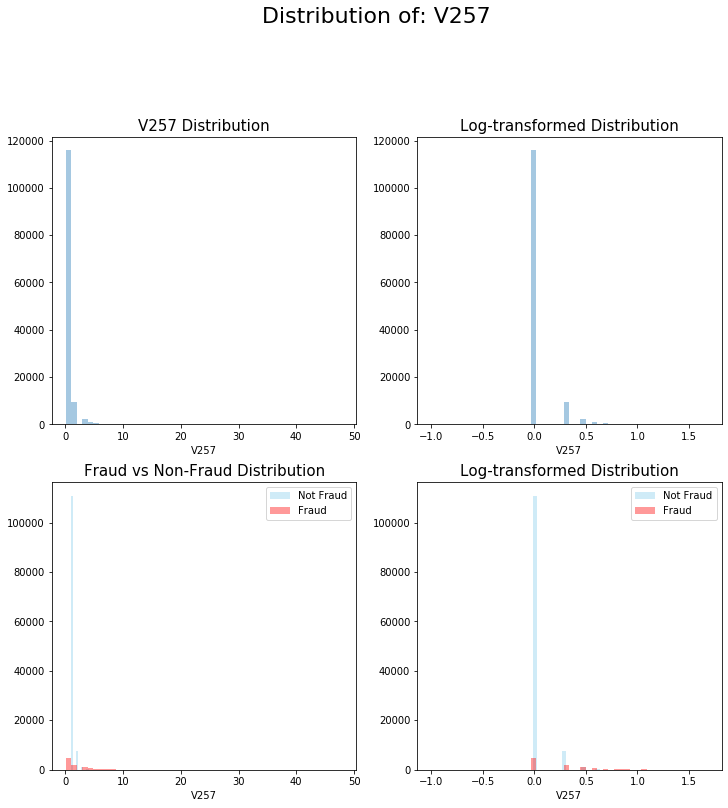

In [61]:
visualize_num_var('V257')

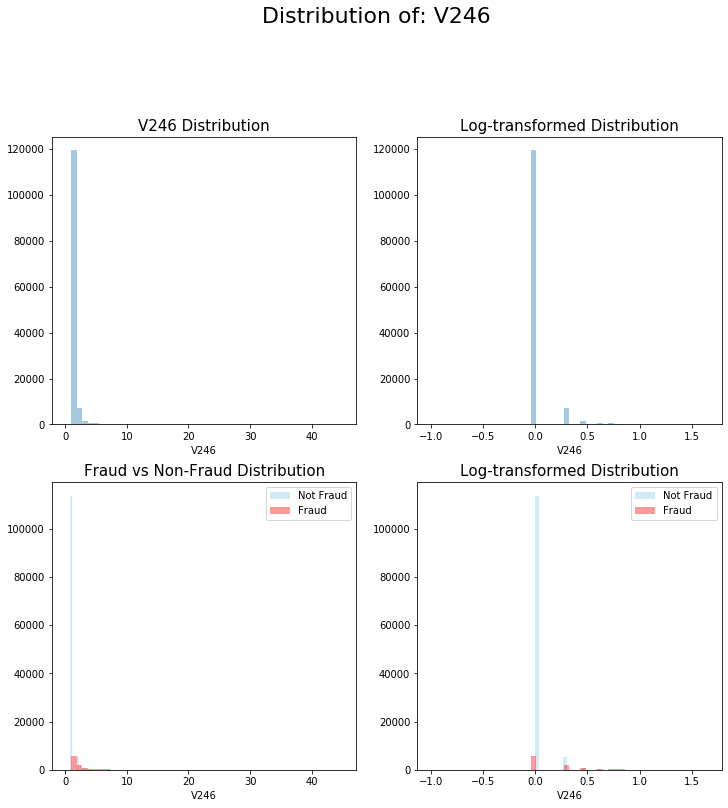

In [62]:
visualize_num_var('V246')

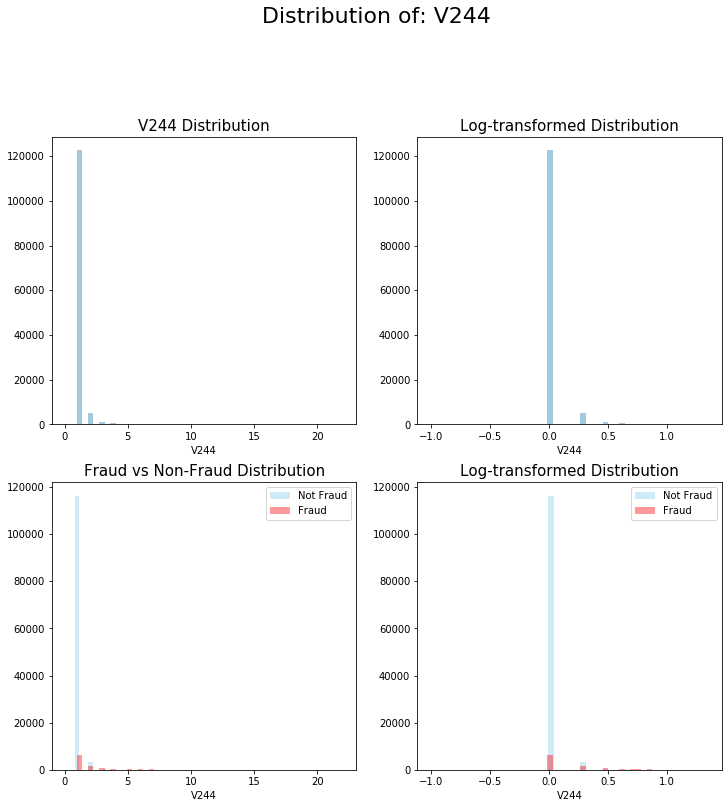

In [63]:
visualize_num_var('V244')

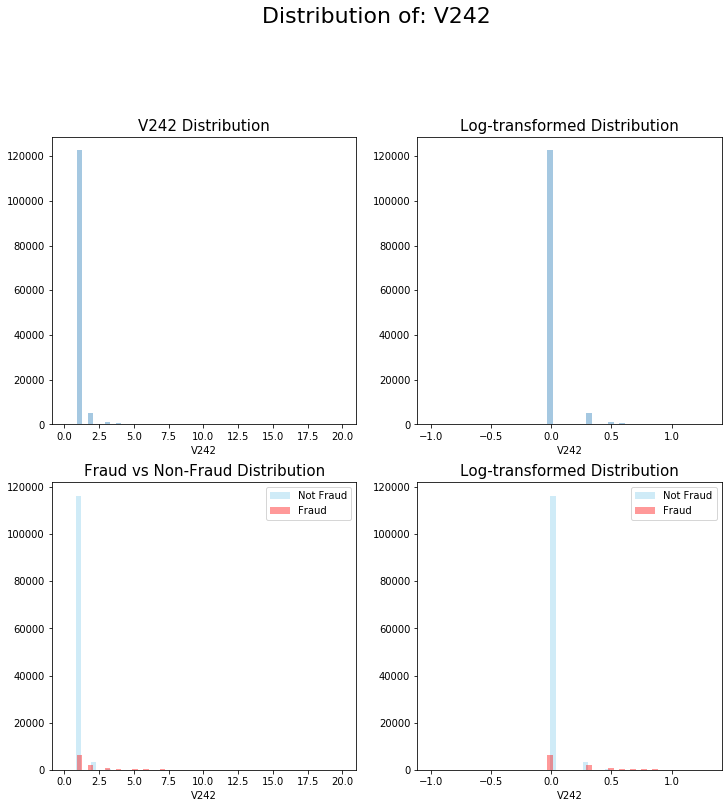

In [64]:
visualize_num_var('V242')

Interesting that there are negative components of the mean of V columns.

## EDA Observations 

To recap:

- There is an imbalance class problem where the occurance of fraud only accounts for 3.5% of the dataset.

- Majority of the columns contain numerous missing values.

- Several columns are related to each other, however, the information is masked which makes understanding each column more difficult.

- Product W has the most instances of fraud, while Product C has the highest fraud rate among product category

- Visa card accounts for the highest frequency of fraud, while Discovery card has the highest fraud rate among card network category.

- Although debit cards are the most popular form of payment, fraud rate for credit cards are much higher (6.6%) than amoung debit cards (2.4%).

# Feature Selection and Engineering 

Since we have identified trends and relationship within the dataset, we will use our findings to select a set of features for our model. 

For this assignment, we will take the following steps for feature selection:

 * select a few numerical variables and two categorical variables
 * log transformation of sale price
 * one-hot encode for categorical variables
 * creating new variables

## Feature Selection 
We will begin by removing features that are precieved to be not relevant to the target variable. 

First, we will drop features with more than 90% missing values. 

In [65]:
# Get columns with >= 90% missing
missing_df = missing_values_table(train)
missing_columns = list(missing_df[missing_df['% of Total Values'] >= 90].index)
print('We will drop %d columns.' % len(missing_columns))
print('Drop columns: ', missing_columns)

Your selected dataframe has 394 columns.
There are 369 columns that have missing values.
We will drop 2 columns.
Drop columns:  ['dist2', 'D7']


In [66]:
# Drop columns 
train.drop(columns=['dist2', 'D7'], axis = 1)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.500,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.000,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.000,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.000,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.000,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2987005,0,86510,49.000,W,5937,555.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2987006,0,86522,159.000,W,12308,360.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2987007,0,86529,422.500,W,12695,490.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2987008,0,86535,15.000,H,2803,100.0,150.0,visa,226.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,2987009,0,86536,117.000,W,17399,111.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Engineer New Features 
In section, we will add new features to model by performing the following:
 * log transformation 
 * combining features
 * imputing missing values with most frequent 
 * encoding categorical variables 

In [67]:
# Function to visualize new features 
def visualize_new_feat(old, new):
    plt.figure(figsize=(12,18))
    
    plt.subplot(2,2,1)
    sns.distplot(train[old], kde= False)
    plt.title('{} Distribution'.format(old), fontsize = 15)
    
    plt.subplot(2,2,2)
    sns.distplot(train[new], kde= False)
    plt.title('{} Distribution'.format(new), fontsize = 15)
    
    plt.subplot(2,2,3)
    sns.distplot(train[train['isFraud'] == 0][old], color = 'skyblue', kde= False, label = 'Not Fraud')
    sns.distplot(train[train['isFraud'] == 1][old], color = 'red', kde= False , label = 'Fraud')
    plt.title('Fraud vs Non-Fraud Distribution', fontsize = 15)
    plt.legend()
    
    plt.subplot(2,2,4)
    sns.distplot(train[train['isFraud'] == 0][new], color = 'skyblue', kde= False, label = 'Not Fraud')
    sns.distplot(train[train['isFraud'] == 1][new], color = 'red', kde= False , label = 'Fraud')
    plt.title('Fraud vs Non-Fraud Distribution', fontsize = 15)
    plt.legend()

#### Log Transformations
Since transaction amount if highly right skewed, we will take the log of this variable. 

In [68]:
# New feature - log of transaction amount
train['TransactionAmt_Log'] = np.log(train['TransactionAmt'])

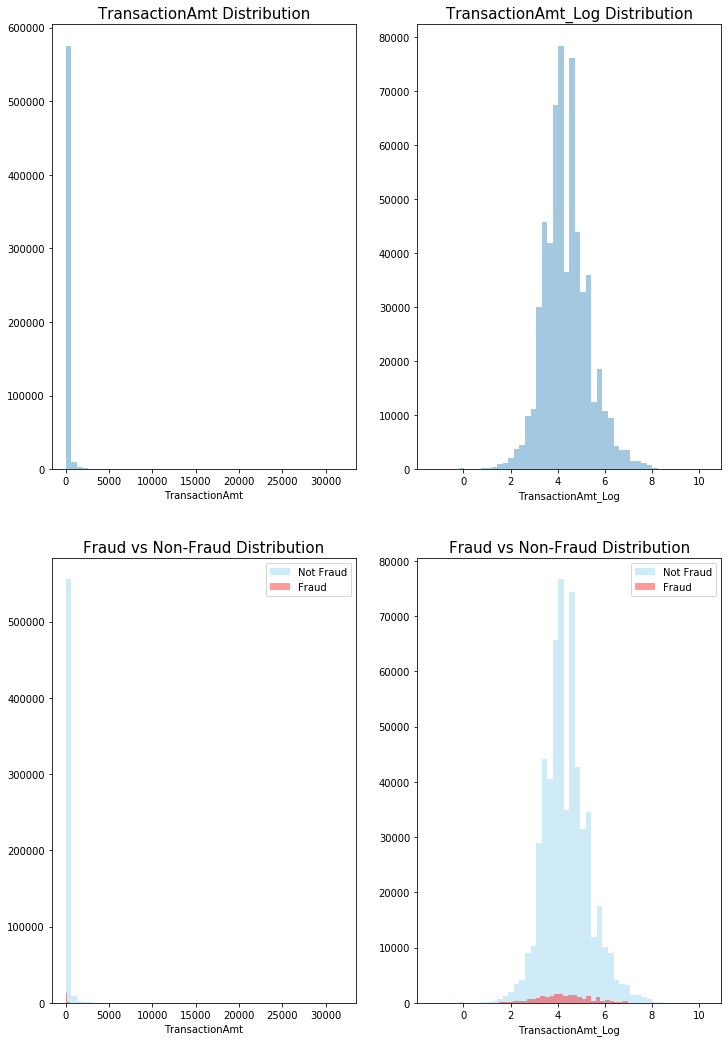

In [69]:
visualize_new_feat('TransactionAmt', 'TransactionAmt_Log')

#### Time Features
We can incorporate the Transaction delta time by interepting the data as seconds. This will allow us to create day of the week which the transaction occured. 

In [70]:
# New feature - day of week in which a transaction 
train['Transaction_day_of_week'] = np.floor((train['TransactionDT'] / (3600 * 24) - 1) % 7)

In [71]:
# New feature - hour of the day in which a transaction happened.
train['Transaction_hour'] = np.floor(train['TransactionDT'] / 3600) % 24

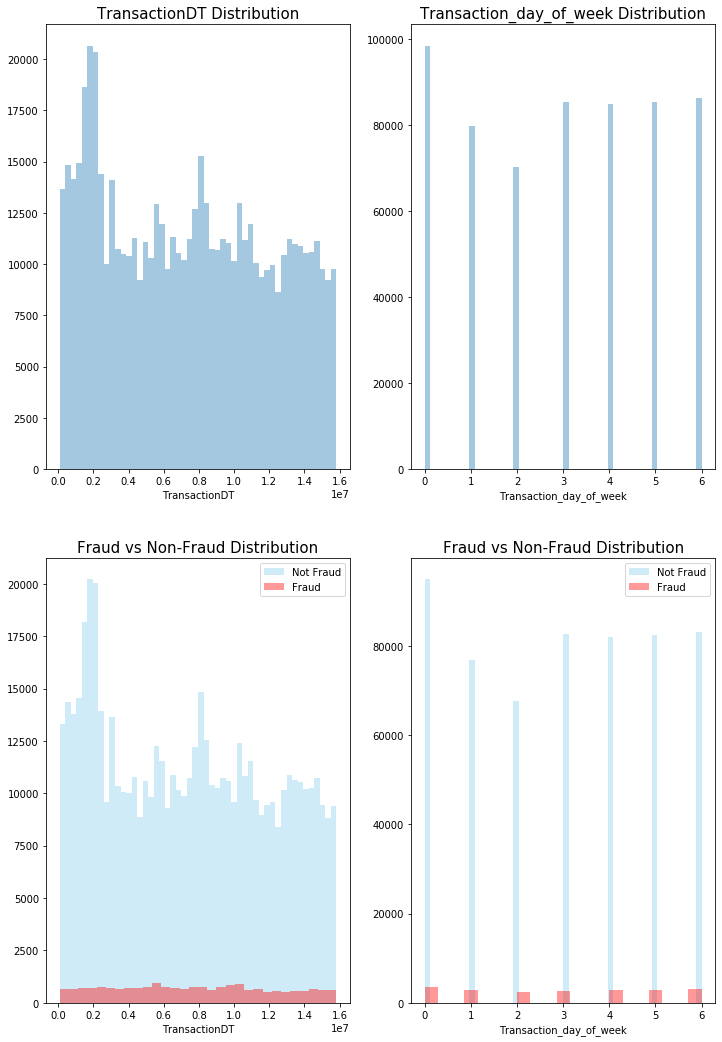

In [72]:
visualize_new_feat('TransactionDT', 'Transaction_day_of_week')

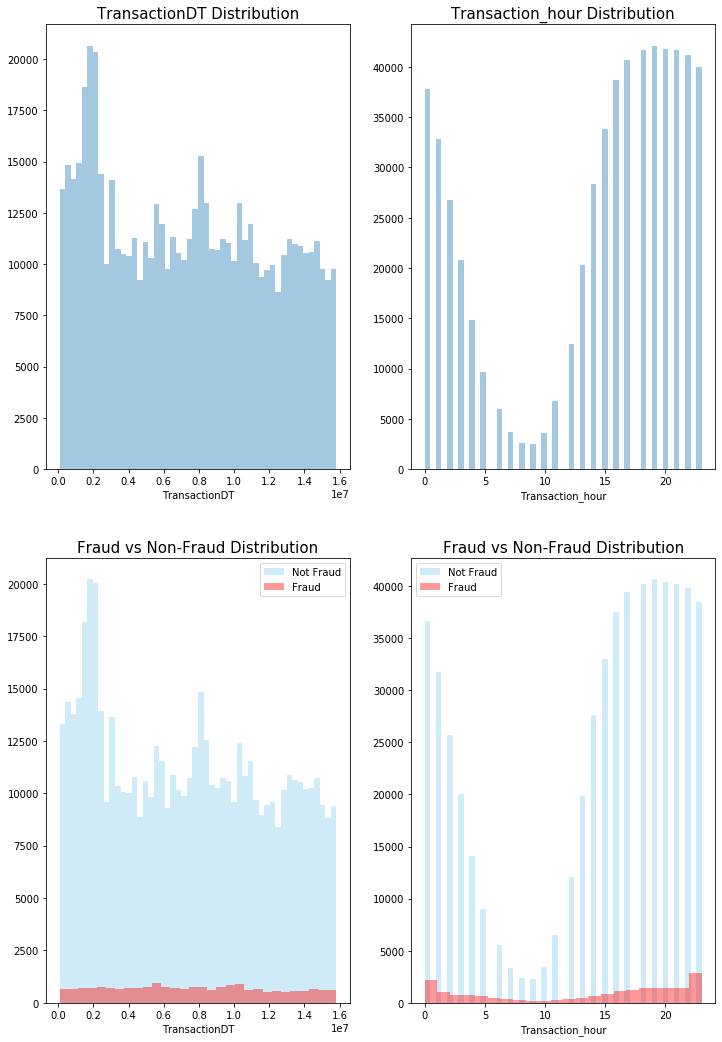

In [73]:
visualize_new_feat('TransactionDT', 'Transaction_hour')

### Encoding Categorical Variables
Before we continue, most machine learning models cannot handle categorical variables well. Therefore, we will have to encode (represent) these variables as numbers before modeling. The two main encoding methods are: 
 * __Label encoding__: assign each unique category in a categorical variable with an integer. No new columns are created.
 * __One-hot encoding__: create a new column for each unique category in a categorical variable. Each observation recieves a 1 in the column for its corresponding category and a 0 in all other new columns.
 
The problem with label encoding is that it gives the categories an arbitrary ordering. The value assigned to each of the categories is random and does not reflect any inherent aspect of the category. 

For this project, we will use Label Encoding for any categorical variables with only 2 categories and One-Hot Encoding for any categorical variables with more than 2 categories. 

In [74]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in train:
    if train[col].dtypes == 'object':
        # If 2 or fewer unique categories
        if len(list(train[col].unique())) <= 2:
            # Train on the training data
            le.fit(train[col])
            # Transform both training and testing data
            train[col] = le.transform(train[col])
            test[col] = le.transform(test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

0 columns were label encoded.


In [75]:
# One-hot encoding of categorical variables
train = pd.get_dummies(train)

print('Training Features shape: ', train.shape)

Training Features shape:  (590540, 539)


# Conclusion

In this notebook, we peformed the first three steps of a machine learning problem. We imported, cleaned, and formatted raw data. Then, we gained an understanding of the data through EDA by identifying trends, anomolies, and the interaction between features and the target variable. From this insight, we performed feature engineering and selection by creating new features and removed onces we deemed irrelevant to detecting fraud. 

In part two, we will establish a baseline model for evaluating the predictive ability of models. Several machine learning methods will be used. The best performing model will be selected for optimization to better detect fraudulent transaction by using  hyperparameter tuning with cross validation. As a final step here, we will save the datasets we developed to use again in the next part.

## Save clean data into CSV

In [76]:
# Save clean data into CSV
train.to_csv('/Users/tsawaengsri/Desktop/Data Science Courses/Datasets/ieee-fraud-detection/clean_train_trans.csv', header=True, index=False)